This notebook tries to answare this:
 
**2. How are YouTube channels interconnected, and what does this connectivity indicate about their influence and reach?**

**This part is only for the gaming category**


**Network Analysis within Gaming Category:**

We plan to identify key influencers and collaboration patterns in the Gaming category. The objective is to construct a network graph representing channels as nodes and collaborations as edges.
Then we will determine centrality measures to identify influential channels and analyze the frequency and scope of collaborations. To identify influential nodes and sub-networks in the games category we can use graph-theoretic measures (Louvain Community Detection). Visualization can be done through the application of NetworkX.

Sources: 
- https://memgraph.com/blog/community-detection-algorithms-with-python-networkx
- https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae



In [1]:
#Import 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import re
import seaborn as sns
import scipy.stats as stats
import os

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx
from collections import defaultdict

In [67]:
!pip install python-louvain

     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/204.6 kB ? eta -:--:--
     ------- ----------------------------- 41.0/204.6 kB 393.8 kB/s eta 0:00:01
     ---------------- -------------------- 92.2/204.6 kB 581.0 kB/s eta 0:00:01
     -------------------------------------- 204.6/204.6 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=40d14e8c2e9f534920761cc1ba742c9195ddab23fb24f7276a394b0c00ec8f70
  Stored in directory: c:\users\bruker\appdata\local\pip\cache\wheels\4d\7c\b6\79b198e4ec43f915fbdf967953d48b89a18893b12aa9df0ae2
Successfully built python-louvain


In [2]:
#Define configuration-related variables 
DATA_path_collab_per_week = "C:\\Users\\Bruker\\ADA_project\\collaborators_per_week.csv"
DATA_path_collab_videos = "C:\\Users\\Bruker\\ADA_project\\dataframe_collaborations_videos.csv"

DEFAULT_ENCODING = 'UTF8'


In [3]:
# Read in data
def read_csv(file, chunk_size=30000): 
    file_path = os.path.join("C:\\Users\\Bruker\\ADA_project\\", file)
    chunk_list = []  # List to hold chunks
    for chunk in pd.read_csv(file_path, encoding=DEFAULT_ENCODING, chunksize=chunk_size):
        chunk_list.append(chunk)
    # Concatenate chunks into single DataFrame, if the csv had been close to the ram, it would be clever to put it in the loop. 
    df = pd.concat(chunk_list, ignore_index=True)
    return df

df_collab_videos = read_csv('dataframe_collaborations_videos.csv')
display(df_collab_videos)

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids
0,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.790269,0.0,y5IvyZlzELs,3442,9.0,2016-09-26,1253.0,NaN
1,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.334071,0.0,m1agc0qT0BY,2407,8.0,2016-09-25,2311.0,NaN
2,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:32.174979,1.0,rr6tfbBA9iY,1820,11.0,2016-09-24,5596.0,NaN
3,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.379061,0.0,ZGll5_wD9Ys,1209,8.0,2016-09-21,792.0,NaN
4,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.020550,426.0,kYkokQgnu20,2053,2076.0,2016-09-21,1141393.0,NaN
...,...,...,...,...,...,...,...,...,...,...
9166272,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:06.375078,12.0,s6mBrPKvumc,558,368.0,2018-09-26,10397.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166273,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.025547,16.0,qneHrPX4_AY,363,574.0,2018-09-25,13954.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166274,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.684503,32.0,4H4Oz0Rjd70,713,596.0,2018-09-24,24198.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166275,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:08.371065,65.0,c_34mr0tXDk,1306,1301.0,2018-09-23,93020.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."


In [4]:
df_collab_per_week = read_csv('collaborators_per_week.csv')
display(df_collab_per_week)

,Year-Week,channel_id,collaborators_in_week
0,2016-00,UC-0Wg1wOUp-bRF1ZiC0dE8g,NaN
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...
2,2016-00,UC-3Oc4KY7pElZMbsWtm3X6A,NaN
3,2016-00,UC-3wJqf60YbC6jzAfPRm2ig,NaN
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1']
...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping']
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w


In [5]:
#Make copys: 
df_collab_per_week.copy()
df_collab_videos.copy() 

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids
0,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.790269,0.0,y5IvyZlzELs,3442,9.0,2016-09-26,1253.0,NaN
1,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.334071,0.0,m1agc0qT0BY,2407,8.0,2016-09-25,2311.0,NaN
2,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:32.174979,1.0,rr6tfbBA9iY,1820,11.0,2016-09-24,5596.0,NaN
3,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.379061,0.0,ZGll5_wD9Ys,1209,8.0,2016-09-21,792.0,NaN
4,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.020550,426.0,kYkokQgnu20,2053,2076.0,2016-09-21,1141393.0,NaN
...,...,...,...,...,...,...,...,...,...,...
9166272,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:06.375078,12.0,s6mBrPKvumc,558,368.0,2018-09-26,10397.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166273,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.025547,16.0,qneHrPX4_AY,363,574.0,2018-09-25,13954.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166274,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.684503,32.0,4H4Oz0Rjd70,713,596.0,2018-09-24,24198.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166275,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:08.371065,65.0,c_34mr0tXDk,1306,1301.0,2018-09-23,93020.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."


In [6]:
df_collab_videos_nonNAN = df_collab_videos.dropna(subset=['final_collaborator_ids'])
df_collab_videos_nonNAN.copy()
display(df_collab_videos_nonNAN)

df_collab_per_week_nonNAN = df_collab_per_week.dropna(subset=['collaborators_in_week'])
display(df_collab_per_week_nonNAN)



,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids
926,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:38.659449,22.0,glNTWlJ-DWo,878,114.0,2018-11-28,2570.0,['UC_0CVCfC_3iuHqmyClu59Uw']
966,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:29:03.770975,36.0,YQx04vMXmcw,391,41.0,2017-05-27,1233.0,['UCCCmzJ3nCLEMYa3YbLmrKEw']
1039,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:29.005273,209.0,r75RJ9tCUXg,668,2581.0,2018-04-25,139470.0,['UC6ofrdxbm3RijOx6NsMU8Sg']
1108,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:10.122731,86.0,g2aaEEGHzQs,809,1529.0,2017-09-21,71869.0,['bentimm1']
1139,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:30.655084,36.0,d23UxeNKbWo,256,225.0,2017-08-22,9952.0,['UCNVnYNZQXjD2_HYsmO3F_rw']
...,...,...,...,...,...,...,...,...,...,...
9166272,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:06.375078,12.0,s6mBrPKvumc,558,368.0,2018-09-26,10397.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166273,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.025547,16.0,qneHrPX4_AY,363,574.0,2018-09-25,13954.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166274,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.684503,32.0,4H4Oz0Rjd70,713,596.0,2018-09-24,24198.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166275,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:08.371065,65.0,c_34mr0tXDk,1306,1301.0,2018-09-23,93020.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."


,Year-Week,channel_id,collaborators_in_week
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1']
7,2016-00,UC-AVK_NtJg6aSYAeEbYnfIw,theDarkElfX
8,2016-00,UC-BG8jc9gI_BpobNXldQuFw,['morachi24' 'BSquaredHD']
18,2016-00,UC-WA0qTCwuMCd418q_6xbEg,krypto9095
...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping']
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w


In [7]:
print(type((df_collab_per_week['collaborators_in_week'].iloc[1])))
display(((df_collab_per_week['collaborators_in_week'].iloc[1])))
print(type((df_collab_per_week['collaborators_in_week'].iloc[0])))
display(((df_collab_per_week['collaborators_in_week'].iloc[0])))


<class 'str'>


"['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jxd_b_QQA'\n 'UCj8pJC0ONCz5zClAewsbSOw']"

<class 'float'>


nan

In [8]:
unique_ids = set()
for row in df_collab_per_week['collaborators_in_week']:
    if pd.notna(row):
        # Remove characters that are not part of IDs and split the string
        cleaned_row = row.replace("[", "").replace("]", "").replace("'", "").replace("\n", " ")
        ids = cleaned_row.split()  # This splits the string on spaces
        for id in ids:
            unique_ids.add(id)

num_unique_ids = len(unique_ids)
print(f"Number of unique IDs: {num_unique_ids}")

Number of unique IDs: 191938


In [9]:
# Step 1: Data Cleaning and Transformation
def clean_and_extract_ids(row):
    # Implement the cleaning and extraction logic here
    # Return a list of channel IDs
    list_channel_ids = []
    try:
        cleaned_row = row.replace("[", "").replace("]", "").replace("'", "").replace("\n", " ").replace("None", "")
        ids = cleaned_row.split()  # This splits the string on spaces
        for id in ids:
            list_channel_ids.append(id)
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
    return list_channel_ids


# Apply the function to each row and create a new column for extracted IDs
df_collab_per_week_nonNAN['extracted_collaborators'] = df_collab_per_week_nonNAN['collaborators_in_week'].apply(clean_and_extract_ids)

display(df_collab_per_week_nonNAN)


C:\Users\Bruker\AppData\Local\Temp\ipykernel_22064\2311125195.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collab_per_week_nonNAN['extracted_collaborators'] = df_collab_per_week_nonNAN['collaborators_in_week'].apply(clean_and_extract_ids)


,Year-Week,channel_id,collaborators_in_week,extracted_collaborators
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...,"[UChm3iPolG6IVrIQ3bc6bIuQ, UCYFn32jjeY0Rx6jxd_..."
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1'],"[ARLNoble, xMattyG1, tiametmarduk1]"
7,2016-00,UC-AVK_NtJg6aSYAeEbYnfIw,theDarkElfX,[theDarkElfX]
8,2016-00,UC-BG8jc9gI_BpobNXldQuFw,['morachi24' 'BSquaredHD'],"[morachi24, BSquaredHD]"
18,2016-00,UC-WA0qTCwuMCd418q_6xbEg,krypto9095,[krypto9095]
...,...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping'],"[albertsunzheng, MrCasping]"
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]


In [10]:
# Function to create edges from a row
def create_edges(row):
    return list(product([row['channel_id']], row['extracted_collaborators']))

chunk_size = 50000
edges = []

for start in range(0, len(df_collab_per_week_nonNAN), chunk_size):
    chunk = df_collab_per_week_nonNAN.iloc[start:start + chunk_size]
    chunk_edges = chunk.apply(create_edges, axis=1).explode().tolist()
    edges.extend(chunk_edges)

print(edges[:10])

[('UC-1pADhAUignVbTbVCW4Uuw', 'UChm3iPolG6IVrIQ3bc6bIuQ'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCYFn32jjeY0Rx6jxd_b_QQA'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCj8pJC0ONCz5zClAewsbSOw'), ('UC-46hTnlyW3aCwjHs2acDzg', 'ARLNoble'), ('UC-46hTnlyW3aCwjHs2acDzg', 'xMattyG1'), ('UC-46hTnlyW3aCwjHs2acDzg', 'tiametmarduk1'), ('UC-AVK_NtJg6aSYAeEbYnfIw', 'theDarkElfX'), ('UC-BG8jc9gI_BpobNXldQuFw', 'morachi24'), ('UC-BG8jc9gI_BpobNXldQuFw', 'BSquaredHD'), ('UC-WA0qTCwuMCd418q_6xbEg', 'krypto9095')]


Number of nodes: 201936
Number of edges: 297276


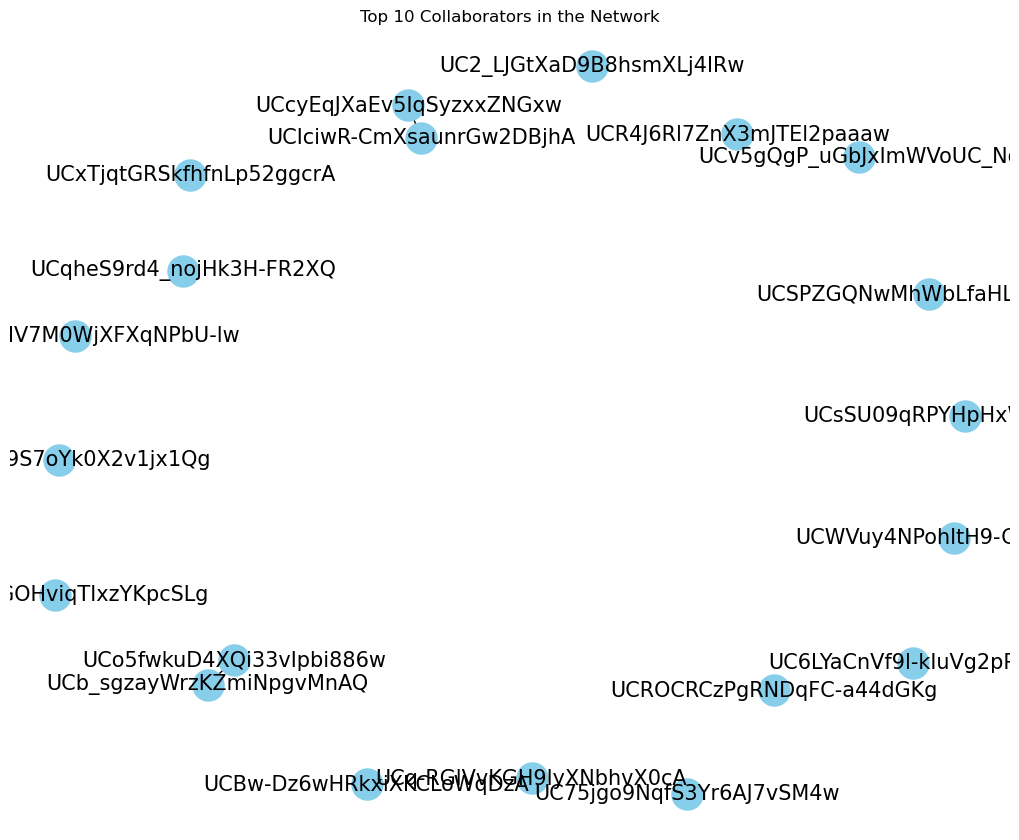

Channel UCBw-Dz6wHRkxiXKCLoWqDzA has 11422 collaborations
Channel UCIciwR-CmXsaunrGw2DBjhA has 3351 collaborations
Channel UCxTjqtGRSkfhfnLp52ggcrA has 2838 collaborations
Channel UCN-v-Xn9S7oYk0X2v1jx1Qg has 1779 collaborations
Channel UCWVuy4NPohItH9-Gr7e8wqw has 1702 collaborations
Channel UCvaCEaGOHviqTIxzYKpcSLg has 1676 collaborations
Channel UC6LYaCnVf9l-kIuVg2pPTHg has 1592 collaborations
Channel UCo5fwkuD4XQi33vIpbi886w has 1525 collaborations
Channel UC2_LJGtXaD9B8hsmXLj4IRw has 1237 collaborations
Channel UCv5gQgP_uGbJxImWVoUC_Ng has 1145 collaborations
Channel UCmXF1HV7M0WjXFXqNPbU-lw has 1074 collaborations
Channel UCROCRCzPgRNDqFC-a44dGKg has 1032 collaborations
Channel UCb_sgzayWrzKZmiNpgvMnAQ has 1020 collaborations
Channel UCqheS9rd4_nojHk3H-FR2XQ has 1000 collaborations
Channel UCR4J6Rl7ZnX3mJTEl2paaaw has 998 collaborations
Channel UC75jgo9NqfS3Yr6AJ7vSM4w has 976 collaborations
Channel UCcyEqJXaEv5IqSyzxxZNGxw has 914 collaborations
Channel UCSPZGQNwMhWbLfaHL6VVLwQ 

In [11]:
# Assuming 'edges' is your complete list of edges
first_1000_edges = edges[:]  # Take the first 1000 edges

# Create the network graph
G = nx.Graph()
G.add_edges_from(first_1000_edges)

# Basic network analysis
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Assuming G is your graph
degree_dict = dict(G.degree())  # Returns a dict where keys are nodes and values are their degree
top_10_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]  # Top 10 nodes

# Create a subgraph with only these top 10 nodes
H = G.subgraph(top_10_nodes)

# Visualization
plt.figure(figsize=(10, 8))
nx.draw(H, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Top 10 Collaborators in the Network")
plt.show()

for node in top_10_nodes:
    print(f"Channel {node} has {degree_dict[node]} collaborations")

**The problem** it does not show how is collaborating with how? It does not give a picture of how they are connected... How can i make connections? Could i look at the top 20 - collaborators, and then make connection between them, and if they id is not in top 20, then it is connected to the outside (say a big box called outside)

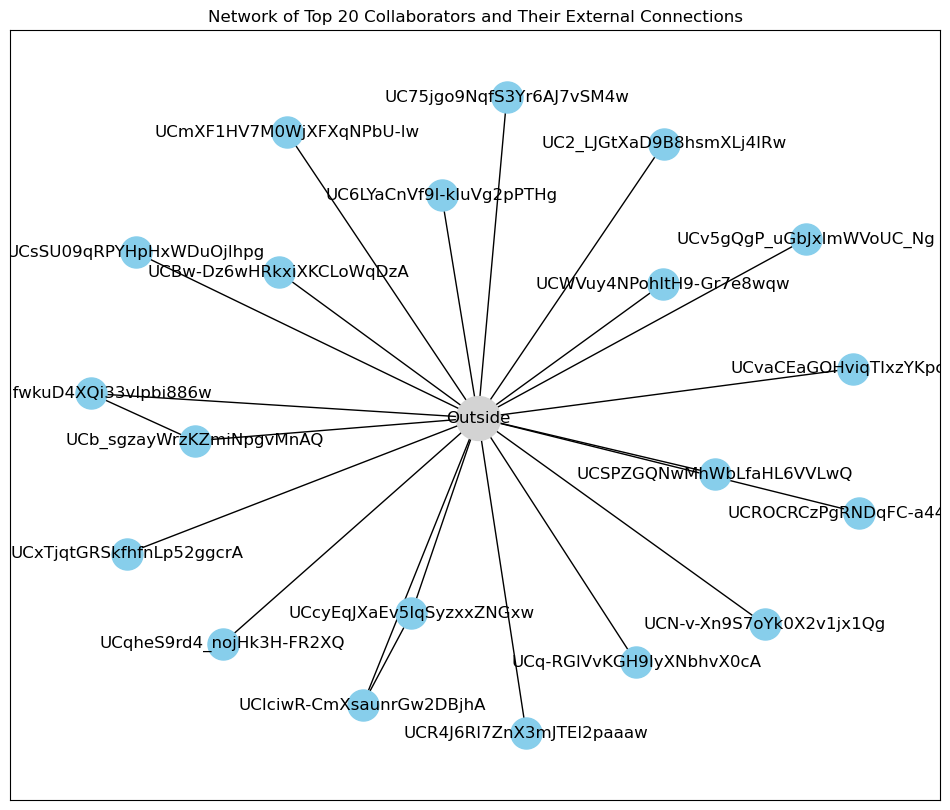

In [12]:
# Get the top 20 collaborators
degree_dict = dict(G.degree())
top_20_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]

# Create a modified graph
H = nx.Graph()
outside_node = "Outside"
for edge in edges:
    if edge[0] in top_20_nodes:
        if edge[1] in top_20_nodes:
            # Both nodes are in the top 20
            H.add_edge(edge[0], edge[1])
        else:
            # The second node is "outside"
            H.add_edge(edge[0], outside_node)
    elif edge[1] in top_20_nodes:
        # The first node is "outside"
        H.add_edge(outside_node, edge[1])

# Visualization
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H)  # Layout for the graph
nx.draw_networkx_nodes(H, pos, nodelist=top_20_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(H, pos, nodelist=[outside_node], node_color='lightgrey', node_size=1000)
nx.draw_networkx_edges(H, pos)
nx.draw_networkx_labels(H, pos)
plt.title("Network of Top 20 Collaborators and Their External Connections")
plt.show()

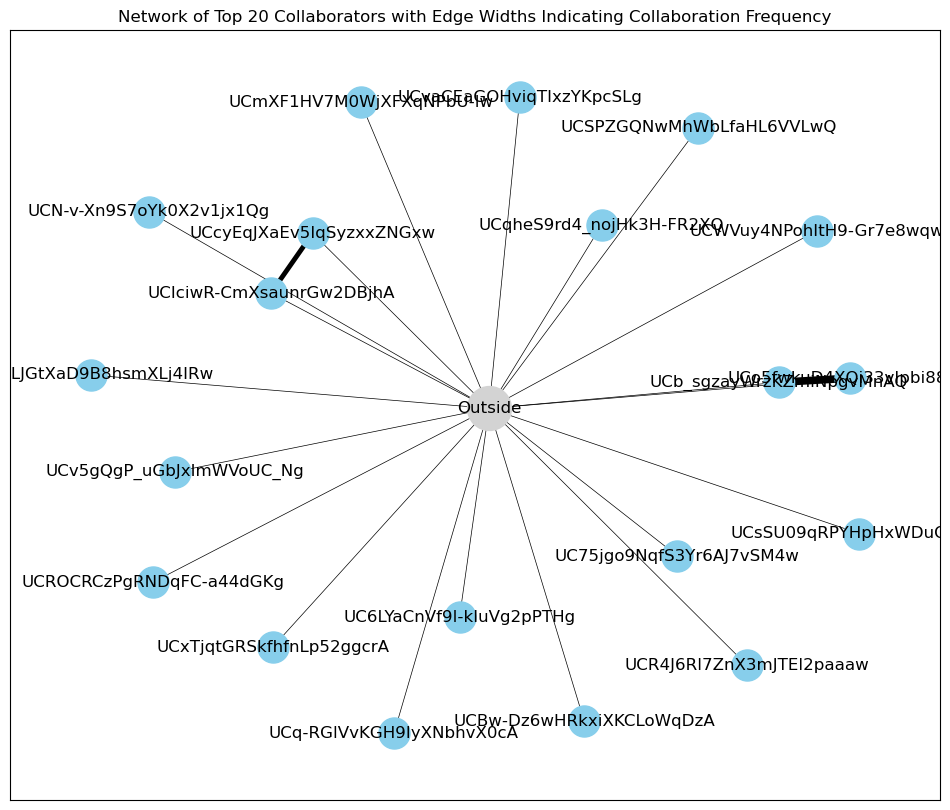

In [13]:
# Count the collaborations
collaboration_count = defaultdict(int)
for edge in edges:
    # Count collaborations for both (node1, node2) and (node2, node1) as the same
    if (edge[1], edge[0]) in collaboration_count:
        collaboration_count[(edge[1], edge[0])] += 1
    else:
        collaboration_count[edge] += 1

# Get the top 20 collaborators
degree_dict = dict(G.degree())
top_20_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]

# Create a modified graph with weighted edges
H = nx.Graph()
outside_node = "Outside"
for edge, weight in collaboration_count.items():
    if edge[0] in top_20_nodes or edge[1] in top_20_nodes:
        # At least one node is in the top 20
        if edge[0] not in top_20_nodes:
            edge = (outside_node, edge[1])
        elif edge[1] not in top_20_nodes:
            edge = (edge[0], outside_node)
        H.add_edge(*edge, weight=weight)

# Visualization
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H)  # Layout for the graph

# Draw nodes
nx.draw_networkx_nodes(H, pos, nodelist=top_20_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(H, pos, nodelist=[outside_node], node_color='lightgrey', node_size=1000)


# Draw edges with widths based on weight
edge_widths = [H[u][v]['weight'] / 2 for u, v in H.edges()]  # Scale for visualization
nx.draw_networkx_edges(H, pos, width=edge_widths)

# Draw labels
nx.draw_networkx_labels(H, pos)

plt.title("Network of Top 20 Collaborators with Edge Widths Indicating Collaboration Frequency")
plt.show()

**Comment** what we see is that 

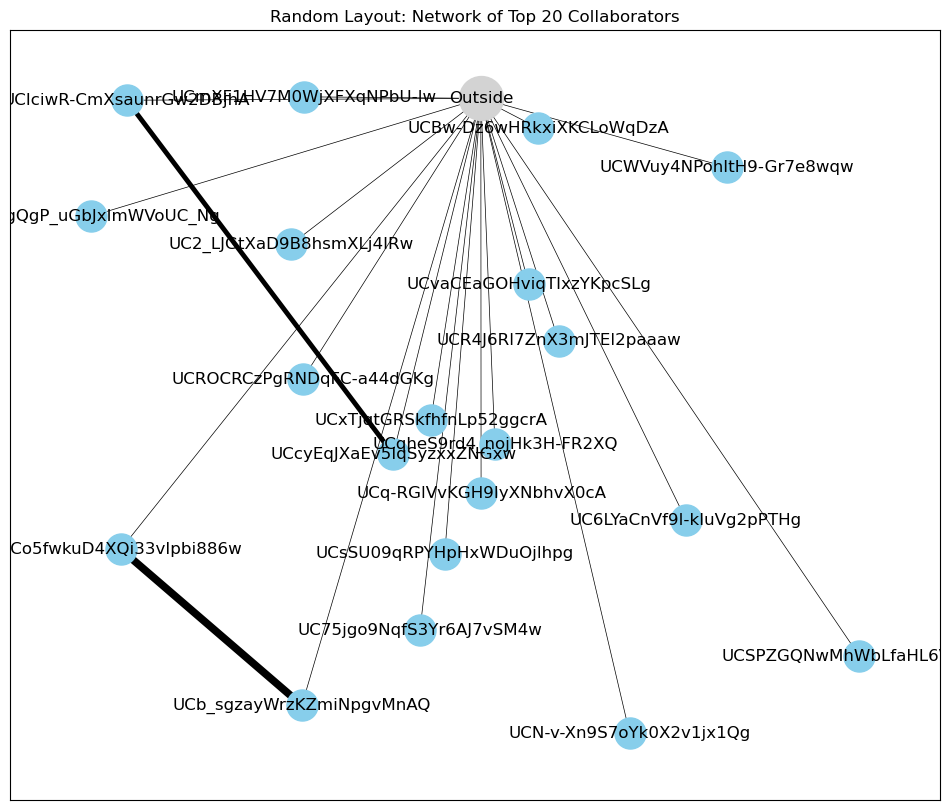

In [14]:
plt.figure(figsize=(12, 10))
pos_random = nx.random_layout(H)  # Random layout
nx.draw_networkx_nodes(H, pos_random, nodelist=top_20_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(H, pos_random, nodelist=[outside_node], node_color='lightgrey', node_size=1000)
nx.draw_networkx_edges(H, pos_random, width=edge_widths)
nx.draw_networkx_labels(H, pos_random)
plt.title("Random Layout: Network of Top 20 Collaborators")
plt.show()


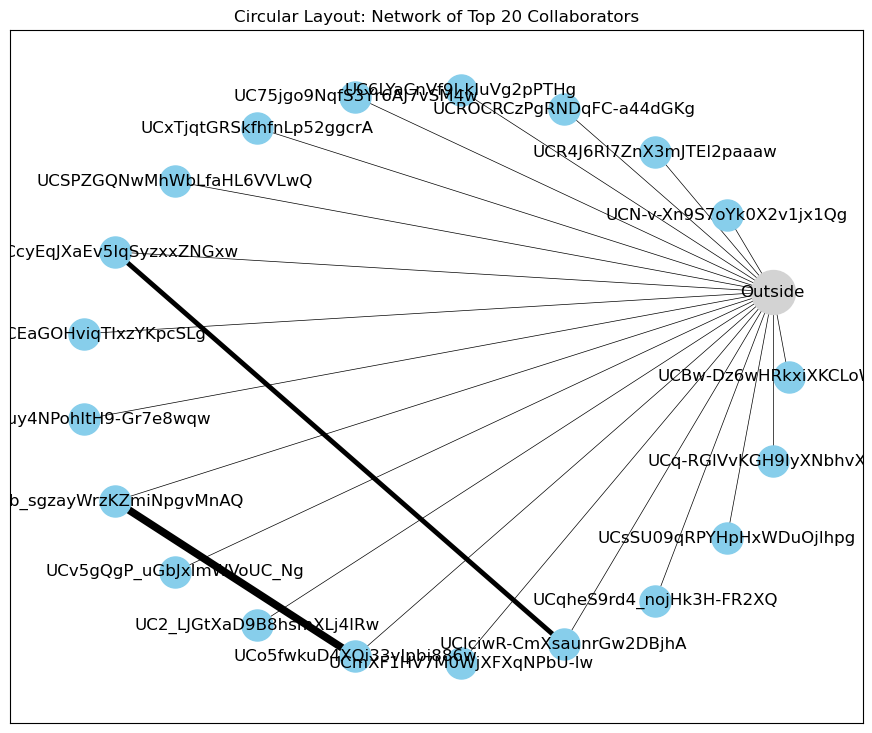

In [15]:
plt.figure(figsize=(11, 9))
pos_circular = nx.circular_layout(H)  # Circular layout
nx.draw_networkx_nodes(H, pos_circular, nodelist=top_20_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(H, pos_circular, nodelist=[outside_node], node_color='lightgrey', node_size=1000)
nx.draw_networkx_edges(H, pos_circular, width=edge_widths)
nx.draw_networkx_labels(H, pos_circular)
plt.title("Circular Layout: Network of Top 20 Collaborators")
plt.show()

What could be cool is to rank after popularity, and then find collaborations. This graph is only between other channels that collaborate a lot. 

Another aspect is two find the network centrality and the different measurements, that we talked about in the method section. 

Need to make some good visualizations. 

There was no problem running the graph on the whole dataset, but i had done some problems when working with the dataframe. 

**Task next time**
1) Start with the different metrics we talked about in the methode. 
2) Try to filter on popularity, and then find the amount of collaborations in the top 20 vs the rest. 
3) Think about the datastory
4) Use excersice on networks to get inspiration

Something to use: 

Triadic Closure:
A friend of my friend is my friend 
Transitivty and clustering coefficient

The networks of quarks... 

Which nodes are most important? 
- Degree, betweenes centrality? 
- Louvian for community detection... 



What do i want to know? 
- The top 20 does not give sense 



In [16]:
print(type(edges))
df_collab_per_week_nonNAN['num_collaborators'] = df_collab_per_week_nonNAN['extracted_collaborators'].apply(len)
# Group by 'channel_id' and sum the 'num_collaborators' for each unique channel
total_collaborators_df = df_collab_per_week_nonNAN.groupby('channel_id')['num_collaborators'].sum().reset_index()

# Rename the summed column to 'total_collaborators'
total_collaborators_df.rename(columns={'num_collaborators': 'total_collaborators'}, inplace=True)

# Display the first few rows of the aggregated DataFrame
total_collaborators_df.sort_values(by = 'total_collaborators',ascending=False).head(10)

<class 'list'>


C:\Users\Bruker\AppData\Local\Temp\ipykernel_22064\3107725041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collab_per_week_nonNAN['num_collaborators'] = df_collab_per_week_nonNAN['extracted_collaborators'].apply(len)


,channel_id,total_collaborators
12662,UCgc8PshAGngxCLCMfoy8NpQ,42082
1240,UC3T-rGMw-wBF8jyeGHP-2cw,21868
6426,UCLcdLec-U0jy2oFhX-MYlsw,15968
6223,UCKy1dAqELo0zrOtPkf0eTMw,14677
7992,UCRK1PxsZXUbt1caLYas1WfA,14445
3556,UCBw-Dz6wHRkxiXKCLoWqDzA,13590
12774,UCgzubI5O6MqKaVwYmpr5xdg,12535
13427,UCjB_adDAIxOL8GA4Y4OCt8g,12477
2657,UC8cwq7G1ZR2mNWsRpM2mhxg,11247
1254,UC3Xu9GSp5-yVa1ck91SjRWA,11032


In [17]:
df_collab_per_week_nonNAN_index_reset = df_collab_per_week_nonNAN.reset_index()
display(df_collab_per_week_nonNAN_index_reset[df_collab_per_week_nonNAN_index_reset['channel_id']=='UCgc8PshAGngxCLCMfoy8NpQ'])
print(df_collab_per_week_nonNAN_index_reset.iloc[1854].loc['extracted_collaborators'])

,index,Year-Week,channel_id,collaborators_in_week,extracted_collaborators,num_collaborators
1854,6752,2016-01,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",108
3594,12880,2016-02,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",138
5388,19138,2016-03,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",228
7199,25472,2016-04,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",345
9031,31841,2016-05,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",300
...,...,...,...,...,...,...
459852,1829452,2019-35,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",106
462317,1840028,2019-36,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",155
464771,1850573,2019-37,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",87
467230,1861124,2019-38,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",128


['PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'Playscop

In [18]:
def remove_duplicates(collab_list):
    """
    Return a list with only unique items.
    """
    return list(set(collab_list))

# Apply the function to the 'extracted_collaborators' column
df_collab_per_week_nonNAN_index_reset['unique_collaborators'] = df_collab_per_week_nonNAN_index_reset['extracted_collaborators'].apply(remove_duplicates)


display(df_collab_per_week_nonNAN_index_reset[df_collab_per_week_nonNAN_index_reset['channel_id']=='UCgc8PshAGngxCLCMfoy8NpQ'])
print(df_collab_per_week_nonNAN_index_reset.iloc[1854].loc['extracted_collaborators'])

,index,Year-Week,channel_id,collaborators_in_week,extracted_collaborators,num_collaborators,unique_collaborators
1854,6752,2016-01,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",108,"[playscopemobile, PlayscopeTimeline, PlayscopeHD]"
3594,12880,2016-02,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",138,"[playscopemobile, PlayscopeTimeline, PlayscopeHD]"
5388,19138,2016-03,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",228,"[playscopemobile, PlayscopeTimeline, PlayscopeHD]"
7199,25472,2016-04,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",345,"[playscopemobile, PlayscopeTimeline, PlayscopeHD]"
9031,31841,2016-05,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...",300,"[playscopemobile, PlayscopeTimeline, PlayscopeHD]"
...,...,...,...,...,...,...,...
459852,1829452,2019-35,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",106,[PlayscopeTrailers]
462317,1840028,2019-36,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",155,[PlayscopeTrailers]
464771,1850573,2019-37,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",87,[PlayscopeTrailers]
467230,1861124,2019-38,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",128,[PlayscopeTrailers]


['PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'Playscop

In [19]:
df_collab_per_week_nonNAN_index_reset['num_collaborators'] = df_collab_per_week_nonNAN_index_reset['unique_collaborators'].apply(len)
# Group by 'channel_id' and sum the 'num_collaborators' for each unique channel
aggregated_collaborators_df = df_collab_per_week_nonNAN_index_reset.groupby('channel_id')['num_collaborators'].sum().reset_index()

# Rename the summed column to 'total_collaborators'
aggregated_collaborators_df.rename(columns={'num_collaborators': 'total_collaborators'}, inplace=True)
aggregated_collaborators_df.sort_values(by = 'total_collaborators',ascending=False).head(10)

,channel_id,total_collaborators
3556,UCBw-Dz6wHRkxiXKCLoWqDzA,13291
5504,UCIciwR-CmXsaunrGw2DBjhA,5904
17519,UCxTjqtGRSkfhfnLp52ggcrA,4209
14892,UCo5fwkuD4XQi33vIpbi886w,3230
13289,UCimN5mkyHUmO3oQsU7c4uYQ,2687
5158,UCHSI8erNrN6hs3sUK6oONLA,2632
2031,UC6LYaCnVf9l-kIuVg2pPTHg,2433
17030,UCvaCEaGOHviqTIxzYKpcSLg,2394
1004,UC2_LJGtXaD9B8hsmXLj4IRw,2243
18254,UCzz9_nzdbrxnErTZPZdZ-cw,2215


In [20]:
display(df_collab_per_week_nonNAN_index_reset[df_collab_per_week_nonNAN_index_reset['channel_id']=='UCBw-Dz6wHRkxiXKCLoWqDzA'])
print(df_collab_per_week_nonNAN_index_reset.iloc[4498].loc['unique_collaborators'])
print(len(df_collab_per_week_nonNAN_index_reset.iloc[4498].loc['unique_collaborators']))

,index,Year-Week,channel_id,collaborators_in_week,extracted_collaborators,num_collaborators,unique_collaborators
140,512,2016-00,UCBw-Dz6wHRkxiXKCLoWqDzA,['the8thhawk' 'UCfsmz-UrT5n47fIOmkGKffQ' 'UCpR...,"[the8thhawk, UCfsmz-UrT5n47fIOmkGKffQ, UCpR8Jr...",12,"[UCg_mgkCaRVo5ThsBmp3axlQ, UCmNBdCIleQ89vrTXDK..."
1009,3729,2016-01,UCBw-Dz6wHRkxiXKCLoWqDzA,['UCtlA_sVsv3V-aa8b2Pc04og' 'the8thhawk' 'UCl6...,"[UCtlA_sVsv3V-aa8b2Pc04og, the8thhawk, UCl6PaL...",8,"[bicboyGaming, skullkruncher13, UCT8iW11Pk6HLE..."
2741,9777,2016-02,UCBw-Dz6wHRkxiXKCLoWqDzA,['UCcIsDQu0gFULvFNPFiYEXyw' 'UCh6OfzCefcCGFfih...,"[UCcIsDQu0gFULvFNPFiYEXyw, UCh6OfzCefcCGFfihPb...",9,"[IamAnexGaming, UC-CbPYT4pz-y4hgyy7PZ2-w, UCh6..."
4498,15998,2016-03,UCBw-Dz6wHRkxiXKCLoWqDzA,['UChv2iANF6XxkD2O2h3UkfNg' 'MountainDoooYT' '...,"[UChv2iANF6XxkD2O2h3UkfNg, MountainDoooYT, Con...",21,"[UCvmDMXpQgtCGH7HH0u46CqQ, UCdXDxh3GQy_mljCFGT..."
6331,22320,2016-04,UCBw-Dz6wHRkxiXKCLoWqDzA,['HypeClue' 'UCe8vY6dlRy7GEtMoOXm6XaQ' 'UCM86i...,"[HypeClue, UCe8vY6dlRy7GEtMoOXm6XaQ, UCM86icot...",30,"[UCqkph2Bhye-QcnnOfLibOYg, UC9rgfW2JDyaCx8djfr..."
...,...,...,...,...,...,...,...
458586,1824174,2019-35,UCBw-Dz6wHRkxiXKCLoWqDzA,['UCh1bzqdI9xyg7VQV8VdpPKQ' 'UCF5JaavLme9fuDwv...,"[UCh1bzqdI9xyg7VQV8VdpPKQ, UCF5JaavLme9fuDwvap...",39,"[UCJv3fmVKB-WWPFB6fLLI0sA, UCKW7g0ccBvPWltwOtn..."
461073,1834777,2019-36,UCBw-Dz6wHRkxiXKCLoWqDzA,['UCd9K41iKHGUmRo5yd8KKW5g' 'UCdAOTVg9Aw7Zu8Jh...,"[UCd9K41iKHGUmRo5yd8KKW5g, UCdAOTVg9Aw7Zu8Jhya...",32,"[UC2kGV-FIsuBBanU9jZWl5Kw, UC5PxkPzD4gcbMsbIFD..."
463509,1845308,2019-37,UCBw-Dz6wHRkxiXKCLoWqDzA,['UChKmCijdi4Dh-owCL43vVhw' 'UCmvhxWXs5Omg9gSZ...,"[UChKmCijdi4Dh-owCL43vVhw, UCmvhxWXs5Omg9gSZcJ...",30,"[UCb3vKpWJ5jGjYJRDxRZvx6w, UCcuVaA3GJhrtjhBDo7..."
465986,1855897,2019-38,UCBw-Dz6wHRkxiXKCLoWqDzA,['UCzAJex9ljXgQBQvbtOKq31g' 'UCCQU-QnZ7X4mpIip...,"[UCzAJex9ljXgQBQvbtOKq31g, UCCQU-QnZ7X4mpIiptk...",24,"[UCCLi2sQm0sHgPd8Ks-z6R0A, UCIEbkDg4ExtW4O-ugm..."


['UCvmDMXpQgtCGH7HH0u46CqQ', 'UCdXDxh3GQy_mljCFGTXQn7g', 'UCa9VxhwsjutiOr5PQhVATjg', 'SpikleSpakle', 'UC_0HSE0lz8Qcf2SCrWyi2XQ', 'StraightUpKnives', 'UCzTDiztMja1vZ5iZpiv_rZw', 'UCfReOOmX66z7KShzUROkf7g', 'UChv2iANF6XxkD2O2h3UkfNg', 'UCyoHyFeVoeUnGzd9bke5T-g', 'MountainDoooYT', 'UCN6fHHi65ToX8GrcPjiJYdg', 'UCPxtACbZurmd3-Cj8wLmiUg', 'Conwayy33', 'UCpDey76U5_1eowqn4G2-xeg', 'UCxntFT9JEtyyL9sW3W1uTUg', 'UCDz1OBaeCbne-rx5yIO8Bfw', 'BlackOpzLegend', 'UCbuBUWIzMXq2Nm0kx9HQjHQ', 'UCjfqFBL0sBJGlzKBNxojJLw', 'UCf01kwOpRwkbFr0i3G1T9NA']
21


count    18259.000000
mean       186.080563
std        747.577689
min          1.000000
25%          3.000000
50%         15.000000
75%         88.000000
max      42082.000000
Name: total_collaborators, dtype: float64


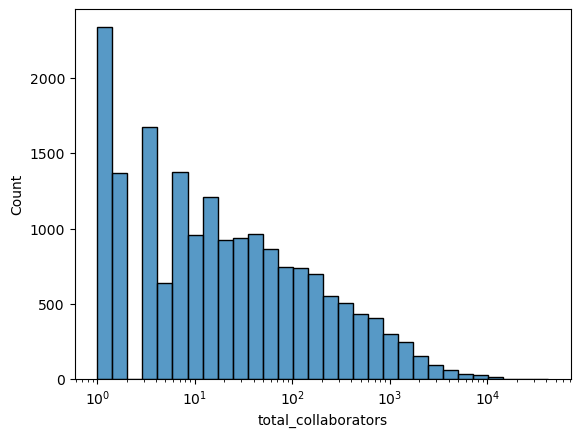

In [21]:
# Inspecting the data
print(total_collaborators_df['total_collaborators'].describe())

# Histogram with adjusted bins and log scale
sns.histplot(total_collaborators_df, x="total_collaborators", bins=30, log_scale=True)
plt.show()

count    18259.000000
mean        64.209376
std        193.155513
min          1.000000
25%          3.000000
50%         12.000000
75%         53.000000
max      13291.000000
Name: total_collaborators, dtype: float64


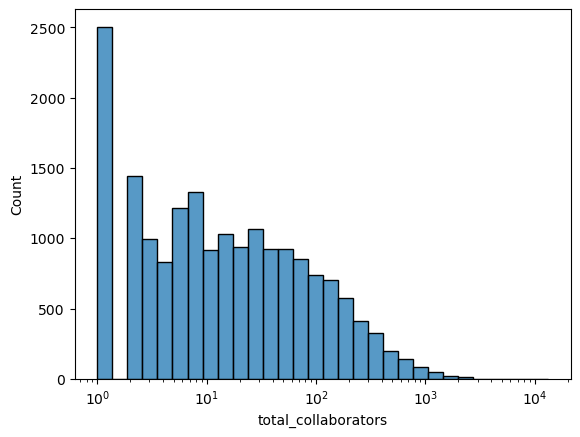

In [22]:
print(aggregated_collaborators_df['total_collaborators'].describe())

# Histogram with adjusted bins and log scale
sns.histplot(aggregated_collaborators_df, x="total_collaborators", bins=30, log_scale=True)
plt.show()

After this we can remove the one with less then 2 collaborations, and start to make a network...
We need to set up edges and so one for this, but think it will be okay. 
Then if it looks okay, i think we can try to define the measurments and the community detection. 

In [43]:
df_collab_per_week_more_than_20 = df_collab_per_week_nonNAN_index_reset[df_collab_per_week_nonNAN_index_reset['num_collaborators']>20]
display(df_collab_per_week_more_than_20)

,index,Year-Week,channel_id,collaborators_in_week,extracted_collaborators,num_collaborators,unique_collaborators
633,2422,2016-00,UCx0dhClMsv0hnALjM1QeBbA,['markiplierGAME' 'PewDiePie' 'theRadBrad' 'ja...,"[markiplierGAME, PewDiePie, theRadBrad, jackse...",21,"[KSIOlajidebtHD, markiplierGAME, ImmortalHDFil..."
748,2830,2016-01,UC29Jr4Cm8XXAMiyKRzCB96g,['UCAeUSJge_yd6nrNb03qnE_A' 'UCCViQ1MSdfO1YLVT...,"[UCAeUSJge_yd6nrNb03qnE_A, UCCViQ1MSdfO1YLVT1k...",85,"[UCxQucktPAEF0d80_xcyU88A, UCDs9, UCSuF5bgQzZz..."
774,2910,2016-01,UC30TPVCVqAwVUSOuHR8AANA,[None 'UCil-fAJO1xmPnFH-FwbIDTg' 'TheMetaFacto...,"[UCil-fAJO1xmPnFH-FwbIDTg, TheMetaFactor, JayY...",23,"[bjplol1995, ScykohCrud, TheMetaFactor, SteaIt..."
939,3500,2016-01,UC9QqBypELbqUVlsg4zMrN0Q,['UniqueRiggers' 'AnEsonGib' 'UChJlLx8SD_B8dXA...,"[UniqueRiggers, AnEsonGib, UChJlLx8SD_B8dXAU1A...",37,"[KSIolajidebt, AllGunsRaving, iLukasx100, Sirh..."
1011,3738,2016-01,UCC-uu-OqgYEx52KYQ-nJLRw,['UCcjtW5d1y81pKr6t-IpacYA' 'UCKnpSaYrnzjBg8uN...,"[UCcjtW5d1y81pKr6t-IpacYA, UCKnpSaYrnzjBg8uN9_...",31,"[UCo3zdhaWsDauswfUT4VFgFA, UCThtqA710k7BvLPnC-..."
...,...,...,...,...,...,...,...
469032,1869182,2019-39,UCZcrAxtPYctVmRhdqjKaAAA,['UCdzi' 'UCOzl' 'UCPlP' 'PforPand' 'UC_wy' 'U...,"[UCdzi, UCOzl, UCPlP, PforPand, UC_wy, UCuz9, ...",26,"[UC2uI, neffexmu, UCq5T, mexgamer, UCYl-, UCOb..."
469091,1869513,2019-39,UCazucVSJqW-kiHMIhQhD-QQ,['UCdkYq-1P-HQ-WhiKIp9LrhQ' 'UCYFG4B0NPnuerDZJ...,"[UCdkYq-1P-HQ-WhiKIp9LrhQ, UCYFG4B0NPnuerDZJP4...",37,"[UCuRfHU1RZEO3piFHZGCmKJw, UC5YjMRj7lh1KkY-FFn..."
469449,1871258,2019-39,UCnafXGuFn4DDwSkejCwRQEQ,['UCoWC5OE123LsPKZZpW3JImA' 'UCqM7t5Gv6xaGPV0Q...,"[UCoWC5OE123LsPKZZpW3JImA, UCqM7t5Gv6xaGPV0Qk-...",33,"[UCNuCglOkzlmQpTGQRTYHCkQ, UC5V6ZtSvTcqttQ_x1z..."
469458,1871281,2019-39,UCnnHqtApBbQDFy0YEnJXKjg,['OmegaGamingLP' 'briannalovestarblast' 'Panda...,"[OmegaGamingLP, briannalovestarblast, PandaFir...",26,"[ZaromaruGames, thepokemonmaster750, gizzy14ga..."


In [44]:
# Function to create edges from a row
def create_edges_new(row):
    return list(product([row['channel_id']], row['unique_collaborators']))

chunk_size = 5000
edges_new = []


for start in range(0, len(df_collab_per_week_more_than_20), chunk_size):
    chunk = df_collab_per_week_more_than_20.iloc[start:start + chunk_size]
    chunk_edges = chunk.apply(create_edges, axis=1).explode().tolist()
    edges_new.extend(chunk_edges)

print(edges_new[:10])
print(np.shape(edges_new))

[('UCx0dhClMsv0hnALjM1QeBbA', 'markiplierGAME'), ('UCx0dhClMsv0hnALjM1QeBbA', 'PewDiePie'), ('UCx0dhClMsv0hnALjM1QeBbA', 'theRadBrad'), ('UCx0dhClMsv0hnALjM1QeBbA', 'jacksepticeye'), ('UCx0dhClMsv0hnALjM1QeBbA', 'KSIOlajidebtHD'), ('UCx0dhClMsv0hnALjM1QeBbA', 'ComedyShortsGamer'), ('UCx0dhClMsv0hnALjM1QeBbA', 'H2ODelirious'), ('UCx0dhClMsv0hnALjM1QeBbA', 'DashieGames'), ('UCx0dhClMsv0hnALjM1QeBbA', 'LordMinion777'), ('UCx0dhClMsv0hnALjM1QeBbA', 'yamimash')]
(160611, 2)


In [25]:
# Function to create edges from a row
def create_edges_new(row):
    return list(product([row['channel_id']], row['unique_collaborators']))

chunk_size = 5000
edges_all = []

df_collab_per_week_nonNAN_index_reset

for start in range(0, len(df_collab_per_week_nonNAN_index_reset), chunk_size):
    chunk = df_collab_per_week_nonNAN_index_reset.iloc[start:start + chunk_size]
    chunk_edges = chunk.apply(create_edges, axis=1).explode().tolist()
    edges_all.extend(chunk_edges)

print(edges_all[:10])
print(np.shape(edges_all))

[('UC-1pADhAUignVbTbVCW4Uuw', 'UChm3iPolG6IVrIQ3bc6bIuQ'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCYFn32jjeY0Rx6jxd_b_QQA'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCj8pJC0ONCz5zClAewsbSOw'), ('UC-46hTnlyW3aCwjHs2acDzg', 'ARLNoble'), ('UC-46hTnlyW3aCwjHs2acDzg', 'xMattyG1'), ('UC-46hTnlyW3aCwjHs2acDzg', 'tiametmarduk1'), ('UC-AVK_NtJg6aSYAeEbYnfIw', 'theDarkElfX'), ('UC-BG8jc9gI_BpobNXldQuFw', 'morachi24'), ('UC-BG8jc9gI_BpobNXldQuFw', 'BSquaredHD'), ('UC-WA0qTCwuMCd418q_6xbEg', 'krypto9095')]
(3397645, 2)


In [45]:
G = nx.Graph()
G.add_edges_from(edges_new)

# Basic description of the graph
def describe_graph(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / float(G.number_of_nodes())}")

describe_graph(G)

Number of nodes: 49373
Number of edges: 57361
Average degree: 2.3235776639053736


In [37]:
G_A = nx.Graph()
G_A.add_edges_from(edges_all)
describe_graph(G_A)

Number of nodes: 201936
Number of edges: 297276
Average degree: 2.9442595673876872


In [28]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [29]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

Number of nodes: 218
Number of edges: 223
Average degree: 2.0458715596330275


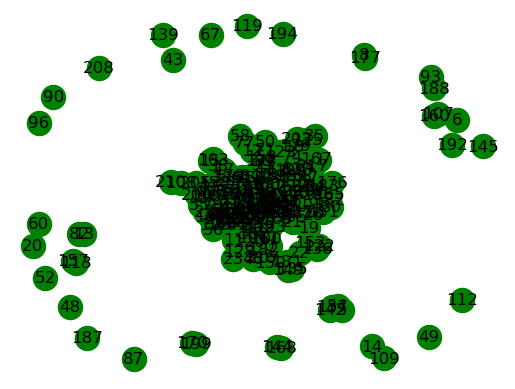

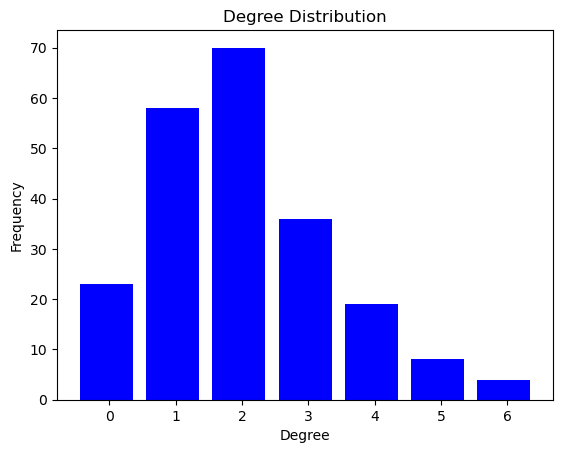

In [30]:
#Make only with bootstraping, take random visualization. 
n = 218
m = 223

erG = nx.gnm_random_graph(n, m)

describe_graph(erG)
visualize_graph(erG, k=0.05, alpha=0.8)
plot_degree_distribution(erG)

In [46]:
import random
sampled_edges = random.sample(edges_new, 30000)

# # Create a graph from the sampled edges
# G_sampled = nx.Graph()
# G_sampled.add_edges_from(sampled_edges)

# # Visualize the graph
# plt.figure(figsize=(12, 12))
# nx.draw(G_sampled, node_size=20, edge_color="gray", with_labels=False)
# plt.title("Sampled Network Visualization")
# plt.show()

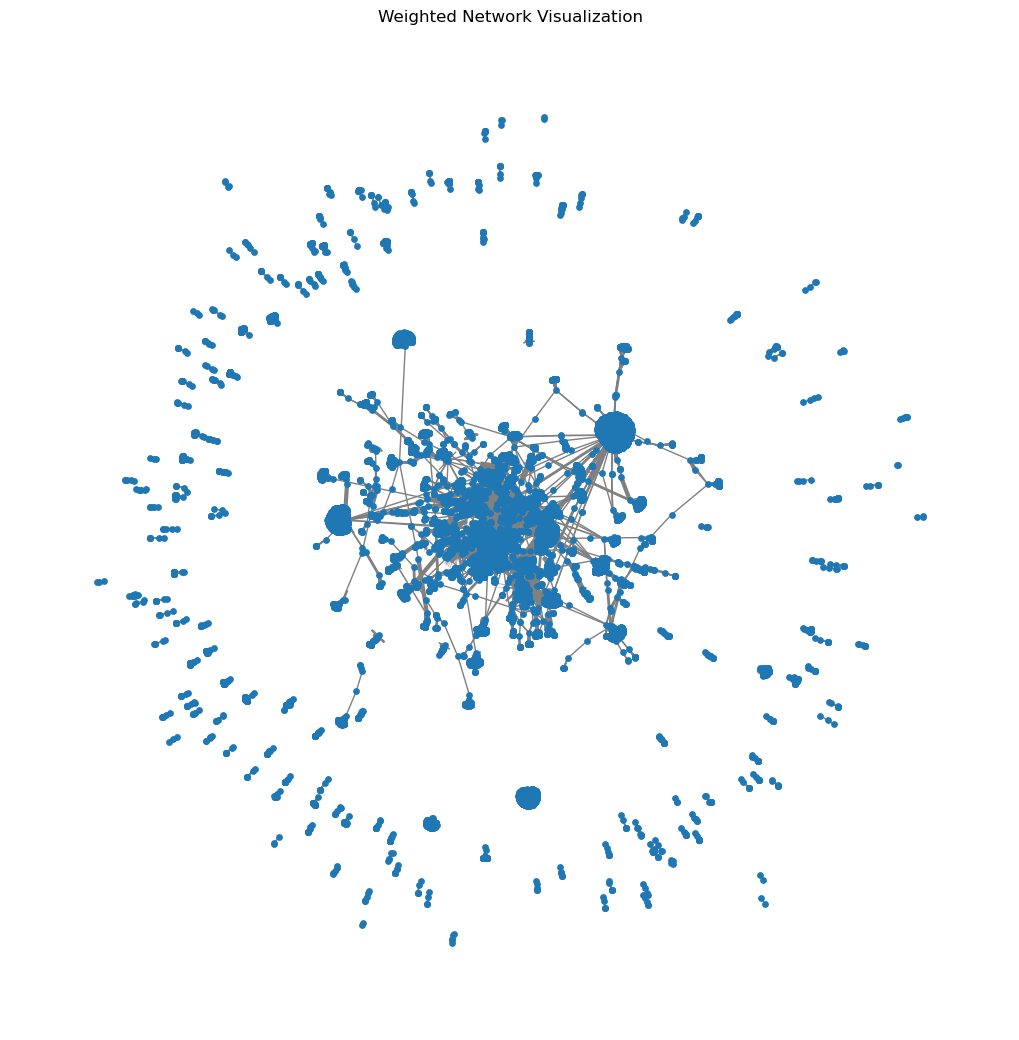

In [47]:
# Create a weighted graph
G_weighted = nx.Graph()

# Adding edges and counting the weight (number of occurrences)
for edge in sampled_edges:
    if G_weighted.has_edge(*edge):
        G_weighted[edge[0]][edge[1]]['weight'] += 1
    else:
        G_weighted.add_edge(*edge, weight=1)

# Extract weights from the graph
weights = [G_weighted[u][v]['weight'] for u, v in G_weighted.edges()]

# Visualize the graph with edge widths based on weights
plt.figure(figsize=(10, 10))
nx.draw(G_weighted, node_size=15, width=weights, edge_color="gray", with_labels=False)
plt.title("Weighted Network Visualization")
plt.show()


This is mostly showing us a picture of how it is, i think we should focus on our research question, find the hubs, and the links between different community, and identifying different communities. 
Get the different measurments data. 

[('UCw-CXGdh1CXal2Koa5OssTA', 'UCGd0SZzQKqaTeT4fPrtTxbg'), ('UCZt51RzGMzRfhc8A92IODhQ', 'Cloudded'), ('UCAyFmGhTVmeSmGvx4ycr09A', 'UC_QHwXH3BX4M2qxnGquXJTw'), ('UCjQ4XV8uNsW0ah0CQrixUow', 'WheelzGa'), ('UC3NDfXlQLQFu7RSTSJhhUXg', 'NoCopyri'), ('UC6cTBSaAcWciALEhGBJS7ig', 'CrateUp'), ('UCHSI8erNrN6hs3sUK6oONLA', 'UCXfjk8C1Hvkax10rrmmjM2Q'), ('UCTj8s8QQHMhjd5dWHdQPjGg', 'UC6G2TAUdLXnJoqOcA6WtDsA'), ('UCIciwR-CmXsaunrGw2DBjhA', 'UCYRbEy3Mk-RTdCd8q7JepOQ'), ('UCVZ4bPMvlD9PQUB0BEt2Pww', 'UCja3ty-X62SlE2pgnLer_mQ'), ('UC2_LJGtXaD9B8hsmXLj4IRw', 'takahata101'), ('UCIciwR-CmXsaunrGw2DBjhA', 'UCS1Is5qnHCbpN-yIFJKmlnw'), ('UC1X9HTMhyL4UpmjgkrN41oQ', 'Nailkaizer891'), ('UC29Jr4Cm8XXAMiyKRzCB96g', 'UC9ObojiZu0k83_Rx7n3LeUg'), ('UCsSU09qRPYHpHxWDuOjlhpg', 'UCx2SFk4PWfe04q0_acz7BfA'), ('UCOds3oNaKqV-a4XQrK6K7Qg', 'MomoLuvsMC'), ('UCwBaEWis0owoaGDxs7Dy-rA', 'UCKlE7Z4n5I8b-n25CvAhTrw'), ('UCu17Sme-KE87ca9OTzP0p7g', 'UCQ0nrWrpU258JDaMAygqPfA'), ('UCv5gQgP_uGbJxImWVoUC_Ng', 'UCz__s4fgqXRmNp-gu72ItZQ'), 

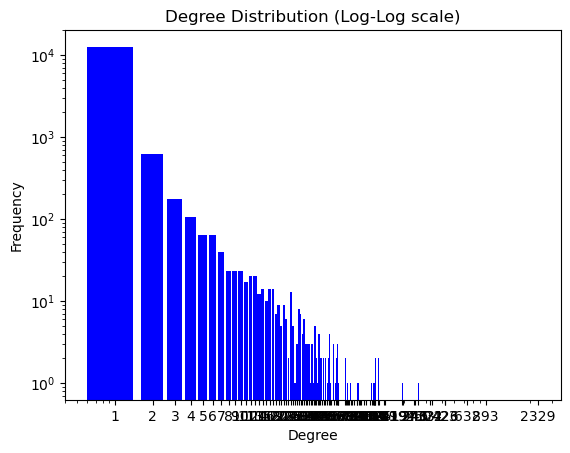

In [51]:
print(sampled_edges[:20])
print(weights[:20])
def plot_log_log_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k, v) in sorted_degree]
    cnt = [v for (k, v) in sorted_degree]

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution (Log-Log scale)")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    plt.xscale('log')
    plt.yscale('log')
    ax.set_xticks([d for d in deg if d > 0])  # Avoid log(0) for degree 0
    ax.set_xticklabels([str(d) for d in deg if d > 0])

    plt.show()

plot_log_log_degree_distribution(G_weighted)

In [59]:
import matplotlib.cm as cm
from operator import itemgetter
import itertools

import warnings
warnings.filterwarnings('ignore')

In [68]:
import collections
from community import community_louvain

In [53]:
print("Network sparsity: %.4f" %nx.density(G_weighted))

Network sparsity: 0.0002


In [55]:
print(nx.is_connected(G_weighted))
comp = list(nx.connected_components(G_weighted))
print('The graph contains', len(comp), 'connected components')

False
The graph contains 177 connected components


In [56]:
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp)/G_weighted.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 

The largest component has 10561 nodes accounting for 75.87 % of the nodes


In [57]:
print('%.4f' %nx.transitivity(G_weighted))

0.0013


In [64]:
degrees = dict(G_weighted.degree(G_weighted.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for channel, degree in sorted_degree[:5]:
    print(channel, 'who is connected to', degree, 'channels')

UCBw-Dz6wHRkxiXKCLoWqDzA who is connected to 2329 channels
UCIciwR-CmXsaunrGw2DBjhA who is connected to 893 channels
UCxTjqtGRSkfhfnLp52ggcrA who is connected to 632 channels
UCo5fwkuD4XQi33vIpbi886w who is connected to 426 channels
UCWVuy4NPohItH9-Gr7e8wqw who is connected to 423 channels


In [95]:
#Katz-is not converging... Why?? 
katz = nx.katz_centrality(G_weighted_2)
nx.set_node_attributes(G_weighted_2, katz, 'katz')
sorted_katz = sorted(katz.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for channel, katzc in sorted_katz[:5]:
    print(channel, 'who is has katz-centrality: %.3f' %katzc)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 1000 iterations')

In [66]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G_weighted)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G_weighted, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for channel, bw in sorted_betweenness[:5]:
    print(channel, 'who is has betweeness: %.3f' %bw)

UCBw-Dz6wHRkxiXKCLoWqDzA who is has betweeness: 0.359
UCxTjqtGRSkfhfnLp52ggcrA who is has betweeness: 0.165
UCv5gQgP_uGbJxImWVoUC_Ng who is has betweeness: 0.110
UCIciwR-CmXsaunrGw2DBjhA who is has betweeness: 0.099
H2ODelirious who is has betweeness: 0.093


In [ ]:
#Most connection: 
# UCBw-Dz6wHRkxiXKCLoWqDzA who is connected to 2329 channels - same 
# UCIciwR-CmXsaunrGw2DBjhA who is connected to 893 channels - same 
# UCxTjqtGRSkfhfnLp52ggcrA who is connected to 632 channels - same 
# UCo5fwkuD4XQi33vIpbi886w who is connected to 426 channels 
# UCWVuy4NPohItH9-Gr7e8wqw who is connected to 423 channels
#NB! THe G_weights is unidirected 


In [79]:
# Assuming G_weighted is your weighted graph - this one is removing everytime it is running...
# Calculate the number of nodes before removal
num_nodes_before = len(G_weighted.nodes())

# List of nodes to remove (nodes with degree less than 10)
nodes_to_remove = [node for node in G_weighted.nodes() if G_weighted.degree(node) < 3]
num_nodes_to_remove = len(nodes_to_remove)

# Remove these nodes from the graph
G_weighted.remove_nodes_from(nodes_to_remove)

# Calculate the number of nodes after removal
num_nodes_after = len(G_weighted.nodes())

# Print the number of nodes
print(f"Number of nodes before removal: {num_nodes_before}")
print(f"Number of nodes removed: {num_nodes_to_remove}")
print(f"Number of nodes after removal: {num_nodes_after}")

Number of nodes before removal: 114
Number of nodes removed: 114
Number of nodes after removal: 0


In [78]:
print(len(G_weighted.nodes()))

114


In [81]:
# Create a weighted graph
G_weighted_2 = nx.Graph()

# Adding edges and counting the weight (number of occurrences)
for edge in sampled_edges:
    if G_weighted_2.has_edge(*edge):
        G_weighted_2[edge[0]][edge[1]]['weight'] += 1
    else:
        G_weighted_2.add_edge(*edge, weight=1)

In [82]:
num_nodes_before = len(G_weighted_2.nodes())

# List of nodes to remove (nodes with degree less than 10)
nodes_to_remove = [node for node in G_weighted_2.nodes() if G_weighted_2.degree(node) < 3]
num_nodes_to_remove = len(nodes_to_remove)

# Remove these nodes from the graph
G_weighted_2.remove_nodes_from(nodes_to_remove)

# Calculate the number of nodes after removal
num_nodes_after = len(G_weighted_2.nodes())

# Print the number of nodes
print(f"Number of nodes before removal: {num_nodes_before}")
print(f"Number of nodes removed: {num_nodes_to_remove}")
print(f"Number of nodes after removal: {num_nodes_after}")

Number of nodes before removal: 13919
Number of nodes removed: 13108
Number of nodes after removal: 811


In [83]:
# Compute betweenness centrality
betweenness_2 = nx.betweenness_centrality(G_weighted_2)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G_weighted_2, betweenness_2, 'betweenness')
sorted_betweenness_2 = sorted(betweenness_2.items(), key=itemgetter(1), reverse=True)

for channel, bw in sorted_betweenness_2[:5]:
    print(channel, 'who is has betweeness: %.3f' %bw)

UCzPKqMawrz7ov21YBEXAZzg who is has betweeness: 0.097
GlitchxCity who is has betweeness: 0.092
NoCopyrightSounds who is has betweeness: 0.086
Flouzemaker who is has betweeness: 0.062
UC-nL_2TP09QuovUwqg6CUOQ who is has betweeness: 0.062


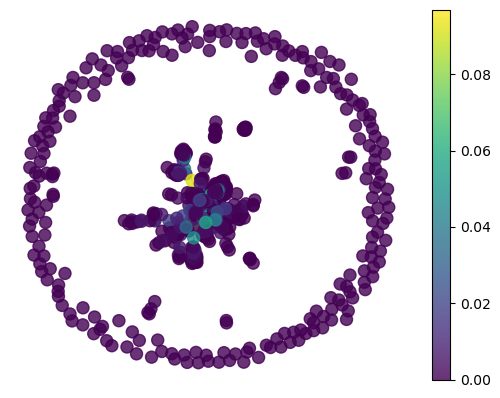

In [86]:
# similar pattern
# List of nodes to remove
#NB! Low degree vs high betweenness?? - Want to connect to one with high betweenness. 
#This runs fast so can do it on the whole sample, while the betweenees are more gready...


list_nodes =list(G_weighted_2.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(G_weighted_2)
ec = nx.draw_networkx_edges(G_weighted_2, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(G_weighted_2, pos, nodelist=list_nodes, node_color=[G_weighted_2.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [87]:
partition = community_louvain.best_partition(G_weighted_2)
# add it as an attribute to the nodes
for n in G_weighted_2.nodes:
    G_weighted_2.nodes[n]["louvain"] = partition[n]

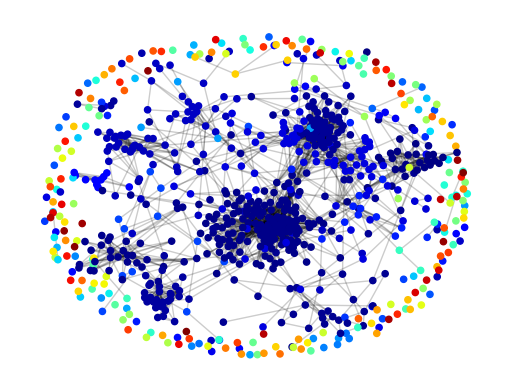

In [88]:
# plot it out
pos = nx.spring_layout(G_weighted_2,k=0.2)
ec = nx.draw_networkx_edges(G_weighted_2, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G_weighted_2, pos, nodelist=G_weighted_2.nodes(), node_color=[G_weighted_2.nodes[n]["louvain"] for n in G_weighted_2.nodes], 
                            node_size=20, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

In [90]:
cluster_1 = partition['GlitchxCity']
# Take all the nodes that belong to James' cluster
members_c = [q for q in G_weighted_2.nodes if partition[q] == cluster_1]
print(len(members_c))

30


In [ ]:
#What can you use this for? The one how has a high centrality, is one you want to connect to. 
#Can we connect this to Jia, so compared what happens when you connect to a channel with high connectivity/betweenees vs a channel with low. 
#That is a cool difference. 

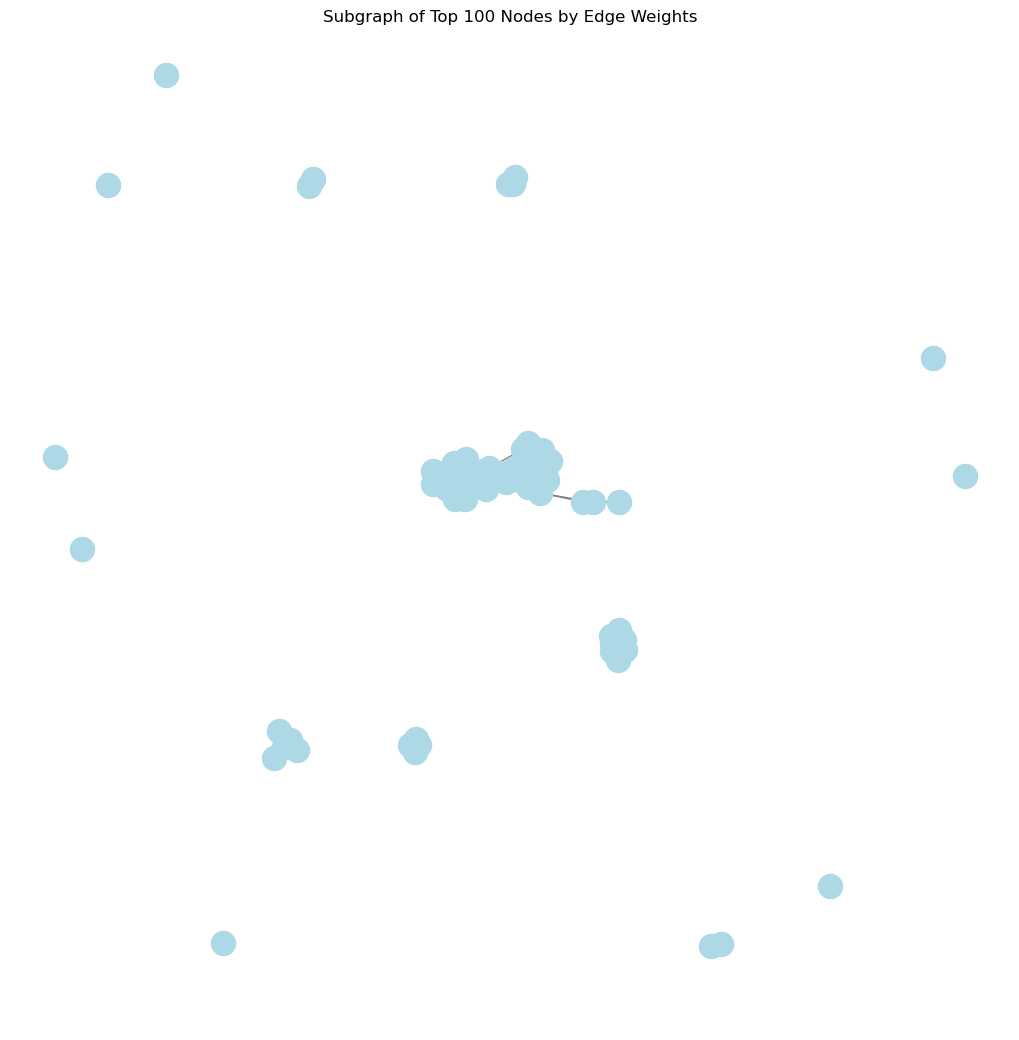

In [93]:
import operator

# Calculate the sum of weights for each node
node_weights = {node: sum(weight for _, _, weight in G_weighted_2.edges(node, data='weight')) for node in G_weighted_2.nodes()}

# Sort nodes by their weights and get the top 100
top_weight_nodes = sorted(node_weights.items(), key=operator.itemgetter(1), reverse=True)[:100]
top_weight_nodes = [node for node, _ in top_weight_nodes]

# Create a subgraph with these top nodes
subgraph_weights = G_weighted_2.subgraph(top_weight_nodes)

# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph_weights, with_labels=None, node_color='lightblue', edge_color='gray')
plt.title("Subgraph of Top 100 Nodes by Edge Weights")
plt.show()


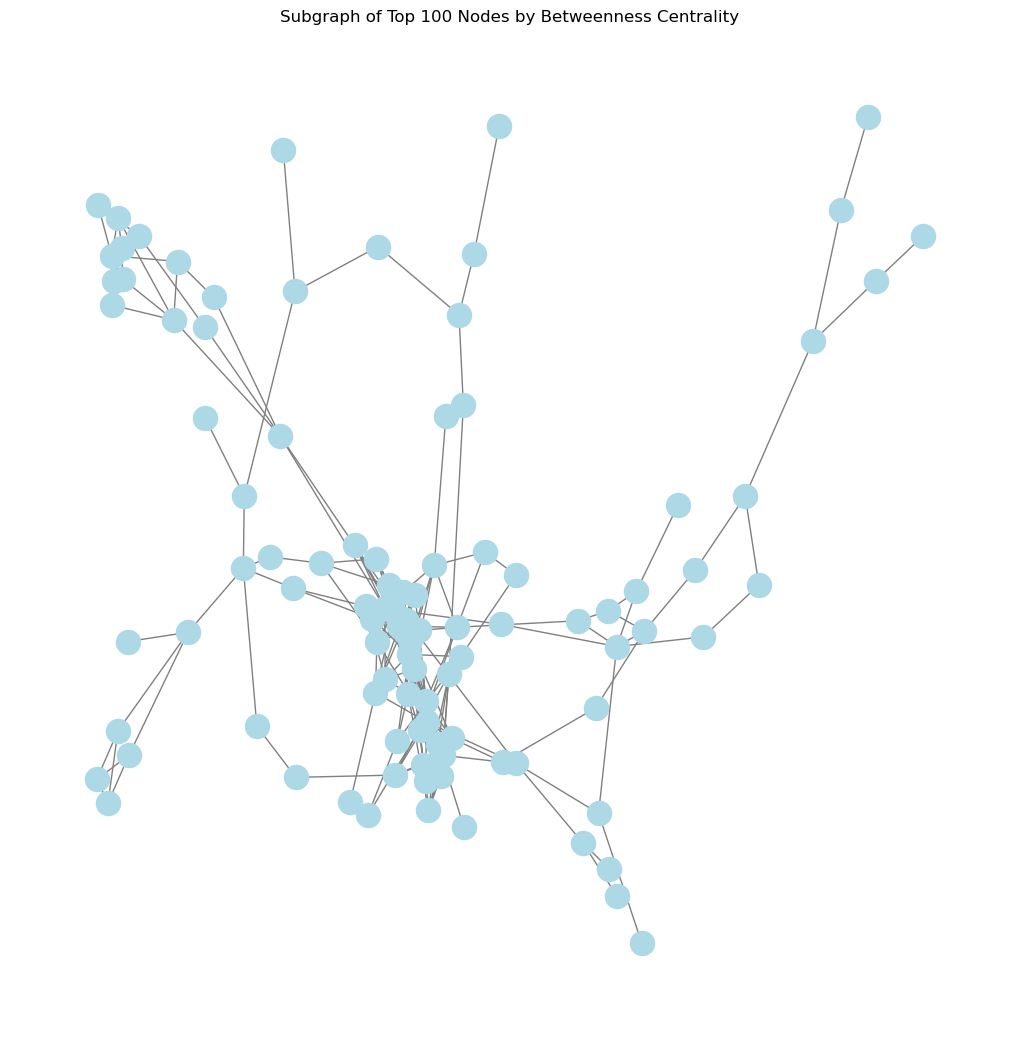

In [94]:
# Calculate betweenness centrality

# Sort nodes by their betweenness centrality and get the top 100
top_betweenness_nodes = sorted(betweenness_2.items(), key=operator.itemgetter(1), reverse=True)[:100]
top_betweenness_nodes = [node for node, _ in top_betweenness_nodes]

# Create a subgraph with these top nodes
subgraph_betweenness = G_weighted_2.subgraph(top_betweenness_nodes)

# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph_betweenness, with_labels=None, node_color='lightblue', edge_color='gray')
plt.title("Subgraph of Top 100 Nodes by Betweenness Centrality")
plt.show()